#### Import Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import openpyxl
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import requests
from tqdm.notebook import tqdm
tqdm.pandas()

Code to change progress bar color to dark from tqdm.

In [27]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

#### Read Data

In [ ]:
mh_scored_df = pd.read_csv('../data/MH_Campaign_Tweets_Sentiment_Scored_1723.csv')
mh_scored_df.head()

In [ ]:
mh_scored_df.shape

(724745, 23)

This equal split in positive and negative sentiment labels may not be idea for our project as not only does it lack the netural class, but it looks biased from its equal split, which may not reflect real life sentiments.

Thus, we may have to perform NLP on the 1.6 million tweets dataset using a model trained from the 2017-2023 dataset, or adopt one from a related work.

#### Data Pre-processing

In [ ]:
mh_scored_df.head()

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,rt_pf,replies_pf,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,0.006309,0.000000,0.022082,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","['people', 'ocd', 'experience', 'intensely', '...","{'neg': 0.242, 'neu': 0.645, 'pos': 0.113, 'co...",-0.8111
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,0.000000,0.000000,0.000000,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"['hello', 'erika', 'iocdf', 'grassroots', 'adv...","{'neg': 0.043, 'neu': 0.821, 'pos': 0.136, 'co...",0.6981
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,0.000000,0.000000,0.000000,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","['light', 'last', 'week', 'ocd', 'awareness', ...","{'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...",0.3400
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,0.000208,0.000000,0.000467,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"['gifs', 'million', 'views', 'giphy', 'hope', ...","{'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...",0.7840
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,0.000208,0.000156,0.000727,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","['ocdweek', 'events', 'activities', 'livestrea...","{'neg': 0.0, 'neu': 0.786, 'pos': 0.214, 'comp...",0.8689


In [ ]:
mh_scored_df.dtypes

ID                    int64
Date                 object
url                  object
username             object
source               object
location             object
tweet                object
likes                 int64
rt                    int64
followers             int64
replies               int64
campaign             object
likes_pf            float64
rt_pf               float64
replies_pf          float64
engagement          float64
engagement_0        float64
processed_tweet      object
year                  int64
tweet_emoji_punc     object
tokenised_tweet      object
sentiment_scores     object
compound_score      float64
dtype: object

In [ ]:
mh_scored_df.isnull().sum()

ID                  0
Date                0
url                 0
username            0
source              0
location            2
tweet               0
likes               0
rt                  0
followers           0
replies             0
campaign            0
likes_pf            0
rt_pf               0
replies_pf          0
engagement          0
engagement_0        0
processed_tweet     0
year                0
tweet_emoji_punc    0
tokenised_tweet     0
sentiment_scores    0
compound_score      0
dtype: int64

There are only 2 missing location values. Let's zoom into what they are exactly

In [ ]:
mh_scored_df[mh_scored_df['location'].isnull()]

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,rt_pf,replies_pf,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score
149763,1181969412020199429,2019-10-09 16:27:22+00:00,https://twitter.com/MNelsonEdD/status/11819694...,MNelsonEdD,Twitter for iPhone,NaN,October is Mental Health Awareness Month. The...,8,2,310,...,0.012903,0.0,0.03871,0.051613,october mental health awareness month help eve...,2019,october mental health awareness month . help e...,"['october', 'mental', 'health', 'awareness', '...","{'neg': 0.121, 'neu': 0.646, 'pos': 0.233, 'co...",0.6124
420817,1392582959253819395,2021-05-12 20:50:25+00:00,https://twitter.com/Craigcooke12/status/139258...,Craigcooke12,Twitter for iPhone,NaN,"@anewton1989 10 months pal, stress 4 figure de...",6,0,238,...,0.000000,0.0,0.02521,0.050420,months pal stress figure debt caused top yr ol...,2021,"@ anewton months pal , stress figure debt ca...","['months', 'pal', 'stress', 'figure', 'debt', ...","{'neg': 0.107, 'neu': 0.852, 'pos': 0.041, 'co...",-0.3071


Here, the missing `location` values are an NaN forme.

In [ ]:
mh_scored_df['location'].value_counts()

location
unknown                         96392
London, England                 29542
United Kingdom                  29106
UK                              22412
London                          21116
                                ...  
Felixstowe / Ealing Broadway        1
Meadow Lake, Saskatchewan           1
Royal Borough                       1
ireland. 24. she/her                1
Instagram - C4PoleFitness           1
Name: count, Length: 58060, dtype: int64

However, under `location`, there is a label 'unknown', which indicates the lack of a provided date. So, we can apply this label on the missing `location` values.

In [ ]:
mh_scored_df['location'].fillna('unknown', inplace=True)

/var/folders/1v/dvtq9m8d48z659z8qvy5rxdh0000gn/T/ipykernel_6260/962037427.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mh_scored_df['location'].fillna('unknown', inplace=True)


In [ ]:
mh_scored_df.isnull().sum()

ID                  0
Date                0
url                 0
username            0
source              0
location            0
tweet               0
likes               0
rt                  0
followers           0
replies             0
campaign            0
likes_pf            0
rt_pf               0
replies_pf          0
engagement          0
engagement_0        0
processed_tweet     0
year                0
tweet_emoji_punc    0
tokenised_tweet     0
sentiment_scores    0
compound_score      0
dtype: int64

And we have solved the missing data issue for `mh_scored_df`.

In [ ]:
mh_scored_df['sentiment_scores'][0]

"{'neg': 0.242, 'neu': 0.645, 'pos': 0.113, 'compound': -0.8111}"

This is how `sentiment_scores` are categorised. <br>
Instead of a final category label of whether it is positive, negative or neutral, it shows us the probability of the data instance being in each of the 3 categories.

When checking through the `one_mill_six` dataset, their label attribute: `target` has divided up the 3 categories into numerical classes: <br>
<ul>
    <li>0 represents a negative sentiment class</li>
    <li>2 represents a neutral sentiment class</li>
    <li>4 represents a positive sentiment class</li>
</ul><br>

Although the data split in `one_mill_six` is not ideal due to its even split between positive and negative, without any neutral, we can still use their labelling convention to transform `sentiment_scores` from `mh_scored_df`.

In [ ]:
sentiment_scores = mh_scored_df['sentiment_scores'].apply(lambda x: ast.literal_eval(x))
sentiment_scores

0         {'neg': 0.242, 'neu': 0.645, 'pos': 0.113, 'co...
1         {'neg': 0.043, 'neu': 0.821, 'pos': 0.136, 'co...
2         {'neg': 0.0, 'neu': 0.925, 'pos': 0.075, 'comp...
3         {'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...
4         {'neg': 0.0, 'neu': 0.786, 'pos': 0.214, 'comp...
                                ...                        
724740    {'neg': 0.0, 'neu': 0.855, 'pos': 0.145, 'comp...
724741    {'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...
724742    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
724743    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
724744    {'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'comp...
Name: sentiment_scores, Length: 724745, dtype: object

Here, we first convert the string attribute into an object.

In [ ]:
sentiment_scores = sentiment_scores.apply(lambda y: {k: v for k, v in y.items() if k != 'compound'})
sentiment_scores

0         {'neg': 0.242, 'neu': 0.645, 'pos': 0.113}
1         {'neg': 0.043, 'neu': 0.821, 'pos': 0.136}
2           {'neg': 0.0, 'neu': 0.925, 'pos': 0.075}
3           {'neg': 0.0, 'neu': 0.848, 'pos': 0.152}
4           {'neg': 0.0, 'neu': 0.786, 'pos': 0.214}
                             ...                    
724740      {'neg': 0.0, 'neu': 0.855, 'pos': 0.145}
724741      {'neg': 0.0, 'neu': 0.899, 'pos': 0.101}
724742      {'neg': 0.0, 'neu': 0.828, 'pos': 0.172}
724743          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0}
724744      {'neg': 0.0, 'neu': 0.602, 'pos': 0.398}
Name: sentiment_scores, Length: 724745, dtype: object

Then, we remove 'compound' from the object. We are only looking for the 3 categories.

In [ ]:
sentiment_scores = sentiment_scores.apply(lambda z : max(z, key=z.get))
sentiment_scores

0         neu
1         neu
2         neu
3         neu
4         neu
         ... 
724740    neu
724741    neu
724742    neu
724743    neu
724744    neu
Name: sentiment_scores, Length: 724745, dtype: object

Next, only keep the class of the highest probability.

In [ ]:
sentiment_scores = sentiment_scores.apply(lambda z: 0 if z == 'neg' else (2 if z == 'neu' else 4))
sentiment_scores

0         2
1         2
2         2
3         2
4         2
         ..
724740    2
724741    2
724742    2
724743    2
724744    2
Name: sentiment_scores, Length: 724745, dtype: int64

And last, we convert it into the `one_mill_six` label format.

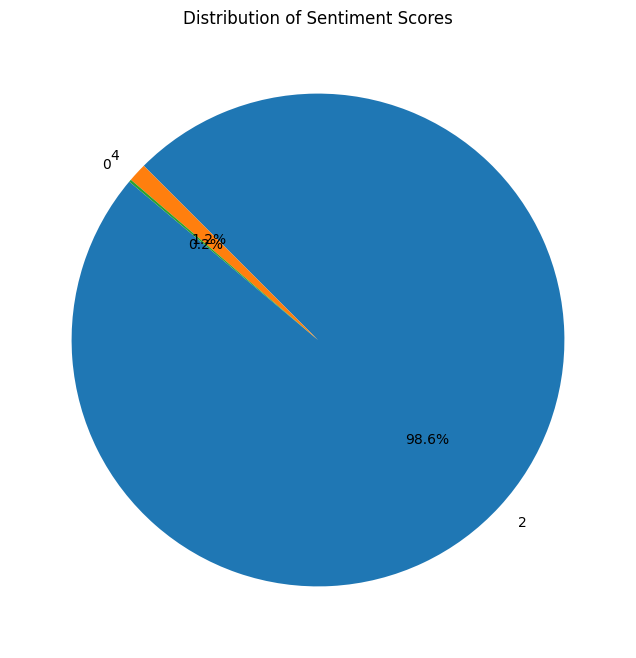

In [ ]:
sentiment_counts = sentiment_scores.value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Scores')
plt.show()

From this pie chart, we notice that the dataset has a high majority of 'neutral' tweets.

In [ ]:
mh_scored_df['sentiment_scores'] = sentiment_scores
mh_scored_df.head()

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,rt_pf,replies_pf,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,0.006309,0.000000,0.022082,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","['people', 'ocd', 'experience', 'intensely', '...",2,-0.8111
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,0.000000,0.000000,0.000000,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"['hello', 'erika', 'iocdf', 'grassroots', 'adv...",2,0.6981
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,0.000000,0.000000,0.000000,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","['light', 'last', 'week', 'ocd', 'awareness', ...",2,0.3400
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,0.000208,0.000000,0.000467,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"['gifs', 'million', 'views', 'giphy', 'hope', ...",2,0.7840
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,0.000208,0.000156,0.000727,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","['ocdweek', 'events', 'activities', 'livestrea...",2,0.8689


Converting the sentiment probabilty scores into a singular consensus sentiment score.

I do have to emphasise on a 'Neutral Sentiment' response, it does not mean that they are in between Positive and Negative, but instead that the text holds no skew on emotions.

Here, `sentiment_scores` are a categorical attribute for sentiment classes, while `compound_score` is a continious classification of sentiment.

In [ ]:
print(mh_scored_df['compound_score'].max())
print(mh_scored_df['compound_score'].min())

0.9999
-0.9975


The range for `compound_score` is rounded to be -1 to +1,, where 0 < x <= 1 is a positive seniment, the close to 1 being the stronger the positivity, and -1 <= x < 0 is a negative sentiment, the close to -1 being a stronger negativity. An absolute 0 sentiment means no sentiment.

In [ ]:
mh_scored_df[mh_scored_df['compound_score'] == 0]['ID'].count()

100718

As shown above, there are tweets that are exactly 0, meaning that they are truly neutral.

In [ ]:
compound_score = mh_scored_df['compound_score']
compound_category = compound_score.apply(
    lambda x: 'Positive' if x > 0 else
              'Negative' if 0 > x else
              'Neutral'
)
compound_category

0         Weak Negative
1              Positive
2              Positive
3              Positive
4              Positive
              ...      
724740         Positive
724741         Positive
724742         Positive
724743          Neutral
724744         Positive
Name: compound_score, Length: 724745, dtype: object

We discretize the continious attribute `compound_score` into a new categorical attribute `compound_categories` to obtain the sentiment group that the tweet is in. <br>
As this scoring follows the correlation matrix range, we will adpot the classification format from it too, grouping the data into 5 main categories as shown above.

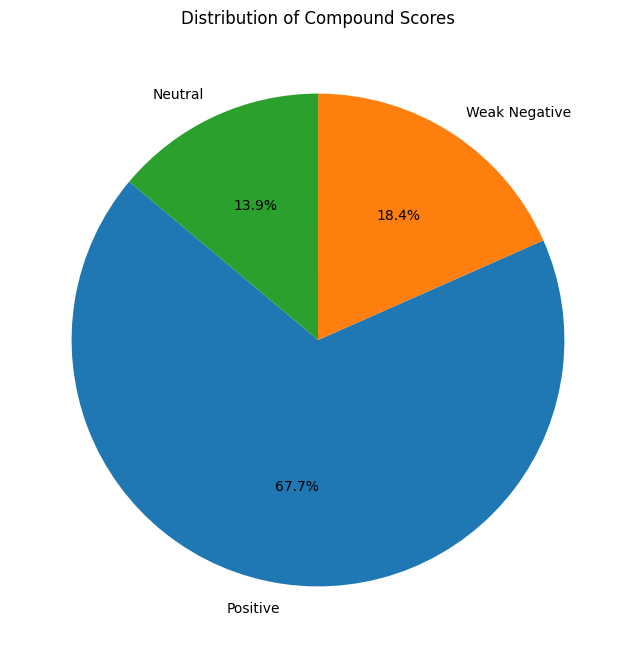

In [ ]:
compound_counts = compound_category.value_counts()

plt.figure(figsize=(8, 8))
plt.pie(compound_counts, labels=compound_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Compound Scores')
plt.show()

When plotting the `compound_categories` onto a pie chart, we now see a stark difference between the `sentiment_scores` and `compound_categories`. <br>
Where `sentiment_scores` have an overwhelming majority in 'neutral', the data here is more evenly split, with 'neutral' taking a back seat, and 'strong positive' being the majority at 47.2%.

In [ ]:
mh_scored_df['compound_category'] = compound_category
mh_scored_df.head()

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,replies_pf,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,0.000000,0.022082,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","['people', 'ocd', 'experience', 'intensely', '...",2,-0.8111,Weak Negative
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,0.000000,0.000000,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"['hello', 'erika', 'iocdf', 'grassroots', 'adv...",2,0.6981,Positive
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,0.000000,0.000000,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","['light', 'last', 'week', 'ocd', 'awareness', ...",2,0.3400,Positive
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,0.000000,0.000467,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"['gifs', 'million', 'views', 'giphy', 'hope', ...",2,0.7840,Positive
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,0.000156,0.000727,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","['ocdweek', 'events', 'activities', 'livestrea...",2,0.8689,Positive


In [ ]:
print(mh_scored_df['tokenised_tweet'][0])
print(type(mh_scored_df['tokenised_tweet'][0]))

['people', 'ocd', 'experience', 'intensely', 'negative', 'repetitive', 'intrusive', 'thoughts', 'chronic', 'feeling', 'doubt', 'danger', 'calm', 'anxiety', 'people', 'ocd', 'often', 'repeat', 'action', 'known', 'compulsions', 'experience', 'therapy', 'help', 'ocdweek', 'ocd', 'https']
<class 'str'>


Similarly to `sentiment_scores`, the dataset has automatically converted it into string, instead of keeping it in its original array format. <br>
Thus, we need to re-convert it back.

In [ ]:
token_tweet = mh_scored_df['tokenised_tweet'].apply(lambda x: ast.literal_eval(x))
token_tweet

0         [people, ocd, experience, intensely, negative,...
1         [hello, erika, iocdf, grassroots, advocate, lo...
2         [light, last, week, ocd, awareness, week, want...
3         [gifs, million, views, giphy, hope, campaign, ...
4         [ocdweek, events, activities, livestreams, led...
                                ...                        
724740       [join, uni, mental, health, day, march, https]
724741    [twitter, accounts, reached, using, unimentalh...
724742    [excited, unimentalhealthday, amp, begin, plan...
724743    [lots, stuff, happening, coming, month, btw, u...
724744    [vibemedia, interested, supporting, us, film, ...
Name: tokenised_tweet, Length: 724745, dtype: object

In [ ]:
type(token_tweet[0])

list

Now, the attribute is in its list/array format, and the data can be retrieved easily and properly.

In [ ]:
mh_scored_df['tokenised_tweet'] = token_tweet

In [ ]:
mh_scored_df.head()

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,replies_pf,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,0.000000,0.022082,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","[people, ocd, experience, intensely, negative,...",2,-0.8111,Strong Negative
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,0.000000,0.000000,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"[hello, erika, iocdf, grassroots, advocate, lo...",2,0.6981,Strong Positive
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,0.000000,0.000000,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","[light, last, week, ocd, awareness, week, want...",2,0.3400,Weak Positive
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,0.000000,0.000467,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"[gifs, million, views, giphy, hope, campaign, ...",2,0.7840,Strong Positive
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,0.000156,0.000727,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","[ocdweek, events, activities, livestreams, led...",2,0.8689,Strong Positive


In [ ]:
mh_scored_df['campaign'].value_counts()

campaign
MHAW    555360
ED       99179
EDAW     46047
UMHD     21104
OCD       3055
Name: count, dtype: int64

The attribute `campaign` comprises of 5 distinct categories of Mental Health Campaigns:
<ul>
    <li>MHAW: Mental Heath Awareness Week</li>
    <li>ED: Eating Disorders</li>
    <li>EDAW: Eating Disorder Awareness Week</li>
    <li>UMHD: University Mental Health Day</li>
    <li>OCD: Obsessive Compulsive Disorder</li>
</ul>

These tweets relate to which Mental Health campaign that specific tweet is commenting on about.

In [ ]:
mh_scored_df['Date'] = pd.to_datetime(mh_scored_df['Date'])

C:\Users\Kwang Zhe\AppData\Local\Temp\ipykernel_17744\3295916601.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  average_compound_score_per_quarter = mh_scored_df.groupby(mh_scored_df['Date'].dt.to_period('Y'))['compound_score'].mean()


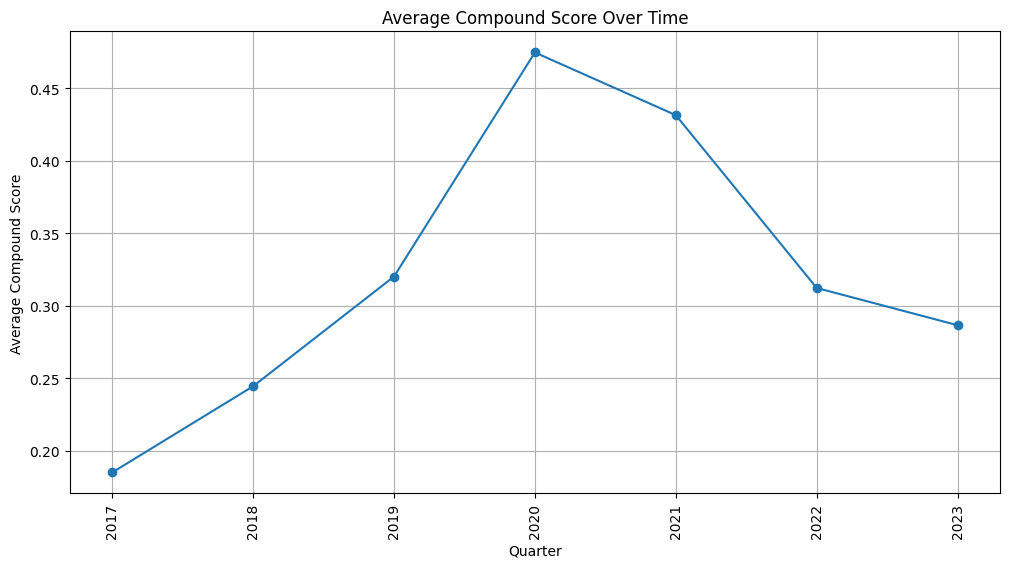

In [ ]:
# Group by date and calculate the average compound score per quarter
average_compound_score_per_quarter = mh_scored_df.groupby(mh_scored_df['Date'].dt.to_period('Y'))['compound_score'].mean()

# Plot the time series graph
plt.figure(figsize=(12, 6))
plt.plot(average_compound_score_per_quarter.index.astype(str), average_compound_score_per_quarter.values, marker='o', linestyle='-')
plt.xlabel('Quarter')
plt.ylabel('Average Compound Score')
plt.title('Average Compound Score Over Time')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

#### Text Processing

In [ ]:
tqdm.pandas()
nltk.download('punkt', download_dir='./nltk_data', quiet=True)
nltk.download('punkt_tab', download_dir='./nltk_data', quiet=True)
nltk.download('wordnet', download_dir='./nltk_data', quiet=True)
nltk.data.path.append('./nltk_data')
stemmer = PorterStemmer()
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
mh_scored_df['alphanum_tweet'] = mh_scored_df['tokenised_tweet'].progress_apply(lambda x: [word for word in x if word.isalnum()])
mh_scored_df.head()

  0%|          | 0/724745 [00:00<?, ?it/s]

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category,alphanum_tweet
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,0.022082,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","[people, ocd, experience, intensely, negative,...",2,-0.8111,Strong Negative,"[people, ocd, experience, intensely, negative,..."
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,0.000000,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"[hello, erika, iocdf, grassroots, advocate, lo...",2,0.6981,Strong Positive,"[hello, erika, iocdf, grassroots, advocate, lo..."
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,0.000000,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","[light, last, week, ocd, awareness, week, want...",2,0.3400,Weak Positive,"[light, last, week, ocd, awareness, week, want..."
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,0.000467,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"[gifs, million, views, giphy, hope, campaign, ...",2,0.7840,Strong Positive,"[gifs, million, views, giphy, hope, campaign, ..."
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,0.000727,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","[ocdweek, events, activities, livestreams, led...",2,0.8689,Strong Positive,"[ocdweek, events, activities, livestreams, led..."


In [ ]:
mh_scored_df['stopword_removed_tweet'] = mh_scored_df['alphanum_tweet'].progress_apply(lambda x: [word for word in x if word not in stopwords])
mh_scored_df.head()

  0%|          | 0/724745 [00:00<?, ?it/s]

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category,alphanum_tweet,stopword_removed_tweet
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","[people, ocd, experience, intensely, negative,...",2,-0.8111,Strong Negative,"[people, ocd, experience, intensely, negative,...","[people, ocd, experience, intensely, negative,..."
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"[hello, erika, iocdf, grassroots, advocate, lo...",2,0.6981,Strong Positive,"[hello, erika, iocdf, grassroots, advocate, lo...","[erika, iocdf, grassroots, advocate, loves, ro..."
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","[light, last, week, ocd, awareness, week, want...",2,0.3400,Weak Positive,"[light, last, week, ocd, awareness, week, want...","[light, week, ocd, awareness, week, wanted, of..."
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"[gifs, million, views, giphy, hope, campaign, ...",2,0.7840,Strong Positive,"[gifs, million, views, giphy, hope, campaign, ...","[gifs, views, giphy, hope, campaign, shifts, p..."
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","[ocdweek, events, activities, livestreams, led...",2,0.8689,Strong Positive,"[ocdweek, events, activities, livestreams, led...","[ocdweek, events, activities, livestreams, led..."


In [ ]:
mh_scored_df['stemmed_tweet'] = mh_scored_df['stopword_removed_tweet'].progress_apply(lambda x: [stemmer.stem(word) for word in x])
mh_scored_df.head()

  0%|          | 0/724745 [00:00<?, ?it/s]

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category,alphanum_tweet,stopword_removed_tweet,stemmed_tweet
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","[people, ocd, experience, intensely, negative,...",2,-0.8111,Strong Negative,"[people, ocd, experience, intensely, negative,...","[people, ocd, experience, intensely, negative,...","[peopl, ocd, experi, intens, neg, repetit, int..."
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"[hello, erika, iocdf, grassroots, advocate, lo...",2,0.6981,Strong Positive,"[hello, erika, iocdf, grassroots, advocate, lo...","[erika, iocdf, grassroots, advocate, loves, ro...","[erika, iocdf, grassroot, advoc, love, rockyou..."
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","[light, last, week, ocd, awareness, week, want...",2,0.3400,Weak Positive,"[light, last, week, ocd, awareness, week, want...","[light, week, ocd, awareness, week, wanted, of...","[light, week, ocd, awar, week, want, offer, si..."
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"[gifs, million, views, giphy, hope, campaign, ...",2,0.7840,Strong Positive,"[gifs, million, views, giphy, hope, campaign, ...","[gifs, views, giphy, hope, campaign, shifts, p...","[gif, view, giphi, hope, campaign, shift, perc..."
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","[ocdweek, events, activities, livestreams, led...",2,0.8689,Strong Positive,"[ocdweek, events, activities, livestreams, led...","[ocdweek, events, activities, livestreams, led...","[ocdweek, event, activ, livestream, led, amaz,..."


Here, we process the text through stop word removal, stemming and tokenization. <br>
Also, it was observed that some of the texts do have non-alphabetic words, which can affect the sentiment during analysis. So we took that into account by only processing and keeping alphabetic words.

#### Feature Extraction/Selection

In [ ]:
mh_scored_df.iloc[:, 0:12].head()

,ID,Date,url,username,source,location,tweet,likes,rt,followers,replies,campaign
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,0,OCD
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,0,OCD
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,0,OCD
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,0,OCD
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,1,OCD


So the breakdown of the first 10 attributes are as such:
<ul>
    <li>ID: Unique identifier for each tweet. This is not important to our project and will thus be omitted.</li>
    <li>Date: Timestamp indicating when the tweet was posted. This will help us determine the time period that this sentiment was mmentioned.</li>
    <li>url: Link to the specific tweet. This does not help us in our objective.</li>
    <li>username: Twitter handle of the user who posted the tweet. This also does not help us.</li>
    <li>source: The platform or device used to post the tweet (e.g., Twitter for iPhone, Twitter Web App). Could be useful, but not our project's objective.</li>
    <li>location: Geographical location of the user who posted the tweet, if available. May be useful is mapping the general sentiment geologically.</li>
    <li>tweet: The original content of the tweet. Since we have the tokenized values of this, we would not need this.</li>
    <li>likes: The number of likes the tweet received. This value is useful in determinin how many like-minded people share this sentiment.</li>
    <li>rt: The number of retweets the tweet received. Similarly, this also indicates how many people share this sentiment.</li>
    <li>followers: The number of followers the user had at the time of posting. This could be an indicator of how many people this sentiment was shared to, which could correlate to the number of likes/reposts the sentiment gets.</li>
</ul>

In [ ]:
mh_scored_df.iloc[:, 12:].head()

,likes_pf,rt_pf,replies_pf,engagement,engagement_0,processed_tweet,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category,alphanum_tweet,stopword_removed_tweet,stemmed_tweet
0,0.015773,0.006309,0.000000,0.022082,0.031546,people ocd experience intensely negative repet...,2023,"people ocd experience intensely negative , rep...","[people, ocd, experience, intensely, negative,...",2,-0.8111,Strong Negative,"[people, ocd, experience, intensely, negative,...","[people, ocd, experience, intensely, negative,...","[peopl, ocd, experi, intens, neg, repetit, int..."
1,0.000000,0.000000,0.000000,0.000000,0.000000,hello erika iocdf grassroots advocate loves ro...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"[hello, erika, iocdf, grassroots, advocate, lo...",2,0.6981,Strong Positive,"[hello, erika, iocdf, grassroots, advocate, lo...","[erika, iocdf, grassroots, advocate, loves, ro...","[erika, iocdf, grassroot, advoc, love, rockyou..."
2,0.000000,0.000000,0.000000,0.000000,0.000000,light last week ocd awareness week wanted offe...,2022,"light last week 's ocd awareness week , wanted...","[light, last, week, ocd, awareness, week, want...",2,0.3400,Weak Positive,"[light, last, week, ocd, awareness, week, want...","[light, week, ocd, awareness, week, wanted, of...","[light, week, ocd, awar, week, want, offer, si..."
3,0.000260,0.000208,0.000000,0.000467,0.000519,gifs million views giphy hope campaign shifts ...,2022,gifs . million views giphy . hope campaign shi...,"[gifs, million, views, giphy, hope, campaign, ...",2,0.7840,Strong Positive,"[gifs, million, views, giphy, hope, campaign, ...","[gifs, views, giphy, hope, campaign, shifts, p...","[gif, view, giphi, hope, campaign, shift, perc..."
4,0.000364,0.000208,0.000156,0.000727,0.000779,ocdweek events activities livestreams led amaz...,2022,"# ocdweek events , activities , livestreams l...","[ocdweek, events, activities, livestreams, led...",2,0.8689,Strong Positive,"[ocdweek, events, activities, livestreams, led...","[ocdweek, events, activities, livestreams, led...","[ocdweek, event, activ, livestream, led, amaz,..."


The breakdown of the remaining attributes are as such:
<ul>
    <li>replies: The number of replies to the tweet. This could be useful to determine the popularity of the sentiment.</li>
    <li>campaign: Likely a categorical label or identifier related to a specific campaign or topic associated with the tweet. More consideration is required before this attribute can be considered for use as our project's goal is to understand mental health trends based on sentiment, not just on tweet topics. So for now we do not include this.</li>
    <li>likes_pf: A normalized value representing likes as a percentage of the user’s followers. This is a better range measurement of likes, as it scales the frequency against the highest and lowest counts.</li>
    <li>rt_pf: A normalized value representing retweets as a percentage of the user’s followers. Same as rt_likes, but with retweets.</li>
    <li>replies_pf: A normalized value representing replies as a percentage of the user’s followers. Same as rt_likes, but with replies.</li>
    <li>engagement: A measure of overall engagement based on likes, retweets, and replies. This is an aggregation of the above 3 attrbutes. Due to this, we can use this instead of likes, retweets and replies, and their of counterparts.</li>
    <li>engagement_0: A baseline engagement value. Due to its similarity to engagement, and to avoid multicolinearity, we will not use this attribute.</li>
    <li>processed_tweet: A version of the tweet after processing for sentiment analysis or text cleaning. With the tokenized tweets attributes, this is not as useful anymore.</li>
    <li>year: The year the tweet was posted. Since we have the fll datetime field earlier on, this is less helpful.</li>
    <li>tweet_emoji_punc: The processed tweet with emoji and punctuation marks handled separately. Still less useful than the final tokenized tweets.</li>
    <li>tokenised_tweet: The tweet after tokenization, i.e., splitting the tweet into individual words or tokens. This will be our main bag of words to conduct further sentiment analysis on.</li>
	<li>sentiment_scores: A numerical sentiment score (likely from a sentiment analysis model). Naturally, this will be our labelled data/dependent variable.</li>
	<li>compound_score: A compound sentiment score indicating the overall sentiment polarity, where negative values suggest negative sentiment and positive values suggest positive sentiment. This is also a crucial attribute to predict sentiment from tweets, and could be more useful that the categorical labels.</li>
    <li>compound_categoy: The classification of the compound scores into strong/weak groups. This can be used over sentiment_scores in categorising, but both can be considered.</li>
</ul>

In [ ]:
mh_scored_df['sentiment'] = mh_scored_df['compound_score'].progress_apply(
    lambda x: 'Negative' if x < 0 else ('Positive' if x > 0 else 'Neutral')
)
mh_scored_df.head()

  0%|          | 0/724745 [00:00<?, ?it/s]

,ID,Date,url,username,source,location,tweet,likes,rt,followers,...,year,tweet_emoji_punc,tokenised_tweet,sentiment_scores,compound_score,compound_category,alphanum_tweet,stopword_removed_tweet,stemmed_tweet,sentiment
0,1625854658601418753,2023-02-15 13:48:52+00:00,https://twitter.com/haringeyiapt/status/162585...,haringeyiapt,Twitter for iPhone,Haringey,"People with OCD experience intensely negative,...",5,1,317,...,2023,"people ocd experience intensely negative , rep...","[people, ocd, experience, intensely, negative,...",2,-0.8111,Strong Negative,"[people, ocd, experience, intensely, negative,...","[people, ocd, experience, intensely, negative,...","[peopl, ocd, experi, intens, neg, repetit, int...",Negative
1,1623813475469344769,2023-02-09 22:37:56+00:00,https://twitter.com/scrupulOCD_KC/status/16238...,scrupulOCD_KC,Twitter for Android,unknown,Hello all I'm Erika an @IOCDF grassroots advoc...,0,0,9,...,2023,hello 'm erika @ iocdf grassroots advocate lov...,"[hello, erika, iocdf, grassroots, advocate, lo...",2,0.6981,Strong Positive,"[hello, erika, iocdf, grassroots, advocate, lo...","[erika, iocdf, grassroots, advocate, loves, ro...","[erika, iocdf, grassroot, advoc, love, rockyou...",Positive
2,1583057973496406016,2022-10-20 11:30:07+00:00,https://twitter.com/FootstepsCandC/status/1583...,FootstepsCandC,SmarterQueue,Gloucester,"In light of last week's OCD Awareness week, we...",0,0,905,...,2022,"light last week 's ocd awareness week , wanted...","[light, last, week, ocd, awareness, week, want...",2,0.3400,Weak Positive,"[light, last, week, ocd, awareness, week, want...","[light, week, ocd, awareness, week, wanted, of...","[light, week, ocd, awar, week, want, offer, si...",Positive
3,1582457044451627008,2022-10-18 19:42:14+00:00,https://twitter.com/IOCDF/status/1582457044451...,IOCDF,Twitter Web App,"Boston, MA",The GIFS now have over 1.4 million views on GI...,5,2,19257,...,2022,gifs . million views giphy . hope campaign shi...,"[gifs, million, views, giphy, hope, campaign, ...",2,0.7840,Strong Positive,"[gifs, million, views, giphy, hope, campaign, ...","[gifs, views, giphy, hope, campaign, shifts, p...","[gif, view, giphi, hope, campaign, shift, perc...",Positive
4,1582457038969262080,2022-10-18 19:42:13+00:00,https://twitter.com/IOCDF/status/1582457038969...,IOCDF,Twitter Web App,"Boston, MA","The 2022 #OCDweek events, activities, and live...",7,2,19257,...,2022,"# ocdweek events , activities , livestreams l...","[ocdweek, events, activities, livestreams, led...",2,0.8689,Strong Positive,"[ocdweek, events, activities, livestreams, led...","[ocdweek, events, activities, livestreams, led...","[ocdweek, event, activ, livestream, led, amaz,...",Positive


In [ ]:
new_mh_scored_df = mh_scored_df[['Date', 'location', 'likes', 'rt', 'followers', 'replies', 'engagement', 'processed_tweet', 'stemmed_tweet', 'sentiment']]
new_mh_scored_df.head()

,Date,location,likes,rt,followers,replies,engagement,processed_tweet,stemmed_tweet,sentiment
0,2023-02-15 13:48:52+00:00,Haringey,5,1,317,0,0.022082,people ocd experience intensely negative repet...,"[peopl, ocd, experi, intens, neg, repetit, int...",Negative
1,2023-02-09 22:37:56+00:00,unknown,0,0,9,0,0.000000,hello erika iocdf grassroots advocate loves ro...,"[erika, iocdf, grassroot, advoc, love, rockyou...",Positive
2,2022-10-20 11:30:07+00:00,Gloucester,0,0,905,0,0.000000,light last week ocd awareness week wanted offe...,"[light, week, ocd, awar, week, want, offer, si...",Positive
3,2022-10-18 19:42:14+00:00,"Boston, MA",5,2,19257,0,0.000467,gifs million views giphy hope campaign shifts ...,"[gif, view, giphi, hope, campaign, shift, perc...",Positive
4,2022-10-18 19:42:13+00:00,"Boston, MA",7,2,19257,1,0.000727,ocdweek events activities livestreams led amaz...,"[ocdweek, event, activ, livestream, led, amaz,...",Positive


In [42]:
new_mh_scored_df.to_csv('../data/mental_health_dataset_cleaned.csv', index=False)

Exporting the cleaned, processed, and feature selected dataset.